# PC Manifold Experiments

March 31, 2022

I am able to show here that RFLO fails to learn when the internal matrix is orthogonal to the readout matrix, but that REINFORCE is able to learn

## 1. Train Network

In [1]:
import numpy as np
import matplotlib.pyplot as plt

# analysis
from sklearn.decomposition import PCA, FactorAnalysis
from sklearn.linear_model import LinearRegression
from scipy import stats, interpolate
from scipy import linalg as LA
from scipy.ndimage.filters import uniform_filter1d

# miscellaneous
from tqdm import tqdm
from itertools import cycle
from copy import deepcopy

import logging
import warnings
import dataclasses
from dataclasses import dataclass
from typing import Optional, List

import sys
sys.path.append("..")

In [2]:
from rnn import RNNparams, RNN
from task import Task
from simulation import Simulation
from algorithms.rflo import RFLO
from algorithms.bptt import BPTT
from algorithms.reinforce import REINFORCE
from algorithms.track_vars import TrackVars

from utils.plotting import plot_trained_trajectories

In [3]:
trial_duration = 20
n_in=4
frac_on = 0.4 # notice here the input duration - this usually makes the task easier

x_tonic = 0.0*np.ones((trial_duration, n_in)) # shape 20 x 4 i.e. time x channel
x_pulse1 = x_tonic.copy()
x_pulse2 = x_tonic.copy()
x_pulse3 = x_tonic.copy()
x_pulse4 = x_tonic.copy()
x_pulse1[0:int(trial_duration*frac_on),0] = 1
x_pulse2[0:int(trial_duration*frac_on),1] = 1
x_pulse3[0:int(trial_duration*frac_on),2] = 1
x_pulse4[0:int(trial_duration*frac_on),3] = 1

task1 = Task(x_in=x_pulse1,y_target=np.asarray([[1],[1]]))
task2 = Task(x_in=x_pulse2,y_target=np.asarray([[-1],[1]]))
task3 = Task(x_in=x_pulse3,y_target=np.asarray([[1],[-1]]))
task4 = Task(x_in=x_pulse4,y_target=np.asarray([[-1],[-1]]))

13it [00:00, 128.70it/s]

n_in: 4
n_rec: 50
n_out: 2
sig_in: 0.01
sig_rec: 0.25
sig_out: 0.01
tau_rec: 8
eta_in: 0.1
eta_rec: 0.25
eta_out: 0.1
g_in: 2.0
g_rec: 1.5
g_out: 2.0
g_fb: 2.0
driving_feedback: False
eta_fb: 0.5
sig_fb: 0.01
feedback_signal: position
velocity_transform: False
tau_vel: 2
dt_vel: 0.1
sig_rec_dim: None
eta_m: None
sig_m: None
lam_m: None
rng: <mtrand.RandomState object at 0x7fdc12aa3ea0>


1500it [00:04, 337.88it/s]


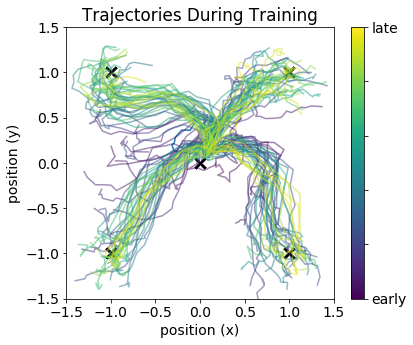

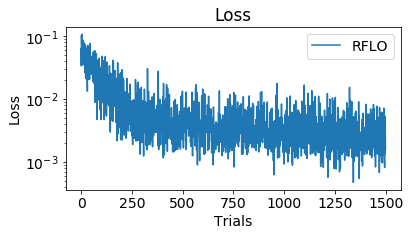

In [4]:
# Set RNN Parameters
# params = RNNparams(n_in=4,n_rec=50,n_out=2,tau_rec=8,
#                eta_in=0.1,eta_rec=0.25,eta_out=0.1,eta_fb=0.5,
#                sig_in=0.01,sig_rec=0.25,sig_out=0.01, sig_fb=0.01,
#                velocity_transform=True, tau_vel = 2, dt_vel = 0.1,
#                driving_feedback=False,
#                rng=np.random.RandomState(1))
params = RNNparams(n_in=4,n_rec=50,n_out=2,tau_rec=8,
               eta_in=0.1,eta_rec=0.25,eta_out=0.1,eta_fb=0.5,
               sig_in=0.01,sig_rec=0.25,sig_out=0.01, sig_fb=0.01,
               velocity_transform=False, tau_vel = 2, dt_vel = 0.1,
               driving_feedback=False,
               rng=np.random.RandomState(2))
params.print_params()

# Initialize RNN
net0 = RNN(params)

# initialize simulation
sim0 = Simulation(net0)

rflo = RFLO(net0,apply_to=['w_rec']) 
sim0.run_session(n_trials=1500, tasks=[task1,task2,task3,task4], learn_alg=[rflo], probe_types=['h','y_out','pos'], plot=True, plot_freq=10)



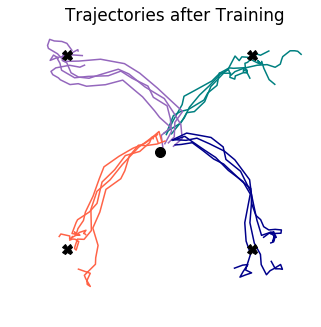

In [5]:
fig = plot_trained_trajectories(sim=sim0, tasks=[task1,task2,task3,task4])


100it [00:00, 139.73it/s]


(20, 50, 1)

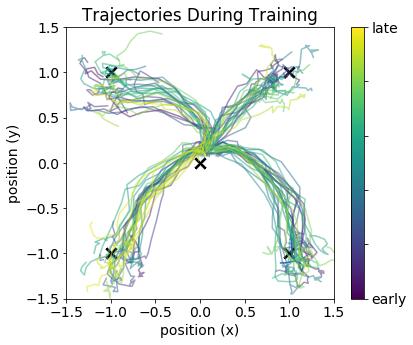

In [7]:
""" Run for 50 trials without learning
Save activity and position output for 50 trials.
This is then used for constructing a decoder.
"""

sim0.run_session(n_trials=100, tasks=[task1,task2,task3,task4], learn_alg=[], probe_types=['h','y_out','pos'], plot=True, plot_freq=1,train=False)

sim0.session_probes['h'][0].shape # 1 for each trial, then (20,200,1) matrix for 200 neurons

## 2. Do PCA on activity, get matrix `C` with PCA

In [8]:
""" Apply PCA """

# concatenate data
activity = sim0.session_probes['h'][0].squeeze()
print(activity.shape)

for i in range(1,len(sim0.session_probes['h'])):
    activity = np.vstack((activity,sim0.session_probes['h'][i].squeeze()))
    
print('n_samples,n_features: ',activity.shape)

(20, 50)
n_samples,n_features:  (2000, 50)


C:  (50, 50)


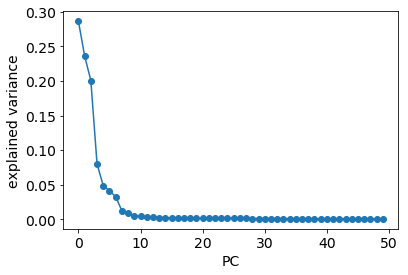

In [9]:
pca = PCA(n_components=50)
pca.fit(activity)
C_all = pca.components_

print('C: ',C_all.shape)
#plt.plot(pca.explained_variance_/np.sum(pca.explained_variance_),'o-') # same dealio
plt.plot(pca.explained_variance_ratio_,'o-')
plt.ylabel('explained variance')
plt.xlabel('PC')
plt.show()


C1:  (4, 50)
C2:  (6, 50)


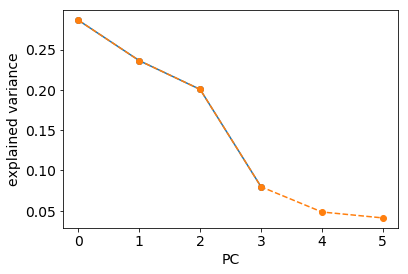

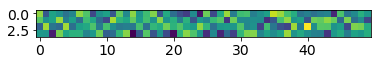

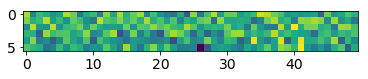

In [10]:
pca = PCA(n_components=4)
pca.fit(activity)
C1 = pca.components_

print('C1: ',C1.shape)
#plt.plot(pca.explained_variance_/np.sum(pca.explained_variance_),'o-') # same dealio
plt.plot(pca.explained_variance_ratio_,'o-')
plt.ylabel('explained variance')
plt.xlabel('PC')

pca = PCA(n_components=6)
pca.fit(activity)
C2 = pca.components_

print('C2: ',C2.shape)
#plt.plot(pca.explained_variance_/np.sum(pca.explained_variance_),'o-') # same dealio
plt.plot(pca.explained_variance_ratio_,'o--')
plt.ylabel('explained variance')
plt.xlabel('PC')
plt.show()

plt.imshow(C1)
plt.show()
plt.imshow(C2)
plt.show()

In [41]:
""" Test that transformation is correct with sklearn"""
activity_lowD_pca = pca.transform(activity)

activity_lowD_test = C @ (activity.T - np.repeat(np.expand_dims(pca.mean_,1),activity.shape[0],axis=1))

np.sum(activity_lowD_pca - activity_lowD_test.T) #test

ValueError: operands could not be broadcast together with shapes (1000,6) (1000,10) 

## 3. Find Decoder `D` with offline regression

12it [00:00, 115.73it/s]

(20, 2)
(2000, 2)
(2, 10)


100it [00:00, 145.56it/s]


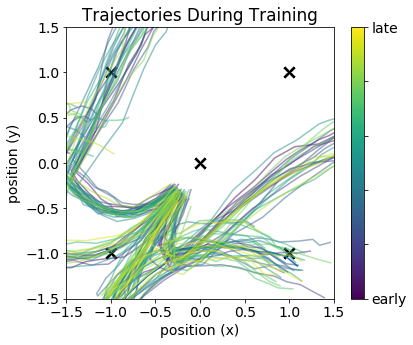

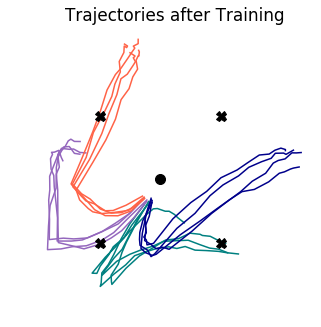

In [11]:


C = C_all[0:10,:] # select first 10

""" Compare with cursor location """
pos = sim0.session_probes['pos'][0].squeeze()
print(pos.shape)

for i in range(1,len(sim0.session_probes['pos'])):
    pos = np.vstack((pos,sim0.session_probes['pos'][i].squeeze()))
print(pos.shape)

lr = LinearRegression(fit_intercept=False)

lr.fit((C @ activity.T).T, pos)
D = lr.coef_

print(D.shape)


""" Test new decoder """

net1 = RNN(params)

net1.set_weights(w_in=np.copy(net0.w_in),w_rec=np.copy(net0.w_rec))

#net1.set_weights(w_out=D@C, w_m=(D@C).T) # set w_out and w_m
""" set weights to just C"""
net1.set_weights(w_out=C[0:2,:], w_m=(C[0:2,:]).T) # set w_out and w_m

# initialize simulation, no learning here
sim1 = Simulation(net1)
# rflo1 = RFLO(net1,apply_to=['w_rec']) 
# sim1.run_session(n_trials=500, tasks=[task1,task2,task3,task4], learn_alg=[rflo1], probe_types=['h','y_out','pos'], plot=True, plot_freq=10,train=True)
sim1.run_session(n_trials=100, tasks=[task1,task2,task3,task4], learn_alg=[], probe_types=['h','y_out','pos'], plot=True, plot_freq=1,train=False)


fig = plot_trained_trajectories(sim=sim1, tasks=[task1,task2,task3,task4])


## Experiment 1 - RFLO with Remapping onto Orthogonal PCs, No Driving Feedback

* Credit Assignment Matrix M is based on top 10 PCs, but decoder is switched to consecutively lower PCs. Since they are orthogonal, will SL _not_ be able to learn the task?

20000it [01:01, 326.65it/s]
20000it [00:45, 443.30it/s]
20000it [00:55, 362.41it/s]


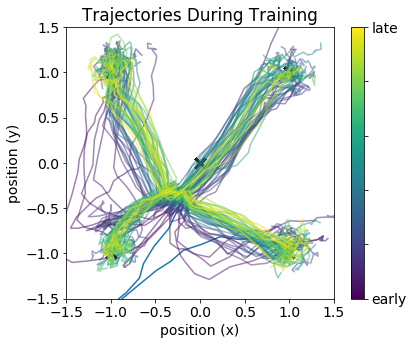

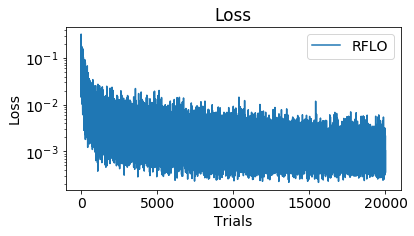

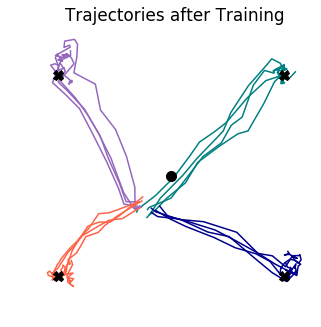

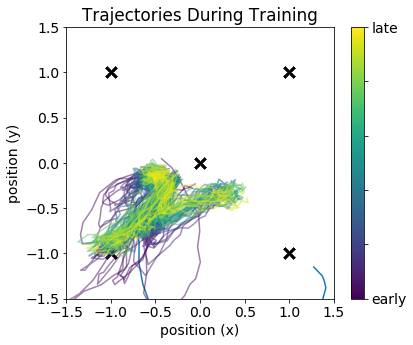

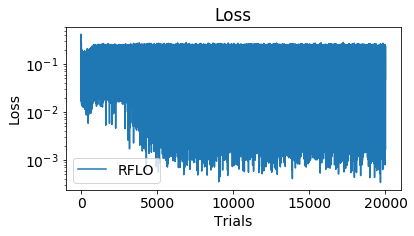

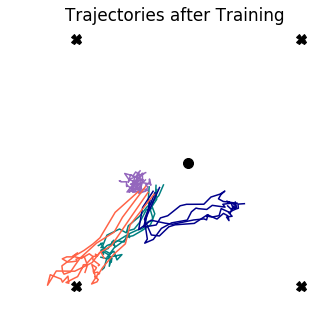

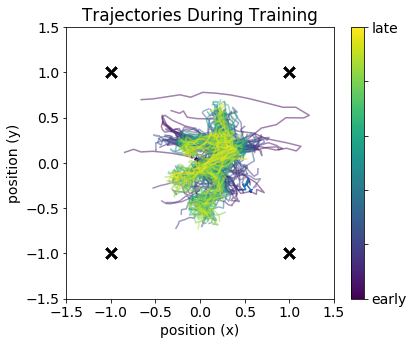

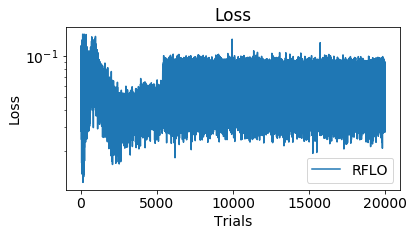

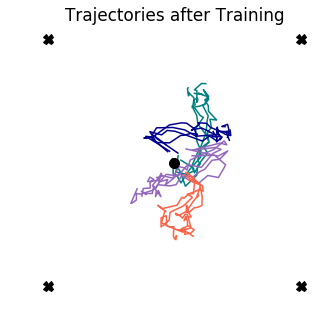

In [12]:
for sl in [slice(0,2),slice(2,4),slice(4,6)]:
    
    """ Test new decoder """

    net1 = RNN(params)

    net1.set_weights(w_in=np.copy(net0.w_in),w_rec=np.copy(net0.w_rec))

    #net1.set_weights(w_out=D@C, w_m=(D@C).T) # set w_out and w_m
    """ set weights to just C"""
    net1.set_weights(w_out=C[sl,:], w_m=(C[0:2,:]).T) # set w_out and w_m << internal matrix is only first two PCs

    # initialize simulation, no learning here
    sim1 = Simulation(net1)
    rflo1 = RFLO(net1,apply_to=['w_rec']) 
    sim1.run_session(n_trials=20000, tasks=[task1,task2,task3,task4], learn_alg=[rflo1], probe_types=['h','y_out','pos'], plot=True, plot_freq=100,train=True)
    #sim1.run_session(n_trials=100, tasks=[task1,task2,task3,task4], learn_alg=[], probe_types=['h','y_out','pos'], plot=True, plot_freq=1,train=False)


    fig = plot_trained_trajectories(sim=sim1, tasks=[task1,task2,task3,task4])


# Experiment 2 - REINFORCE, with No Driving Feedback

20000it [00:41, 487.80it/s]
20000it [00:49, 309.88it/s]
20000it [01:24, 237.73it/s]


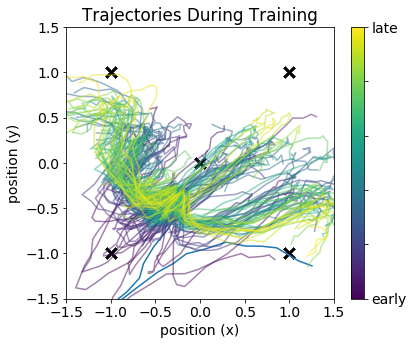

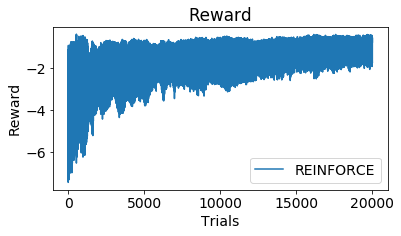

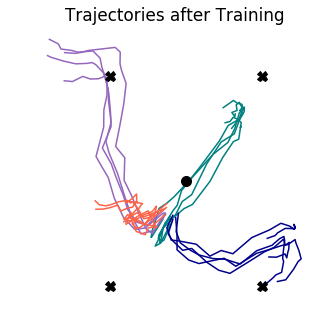

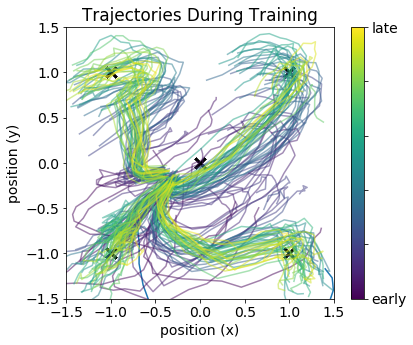

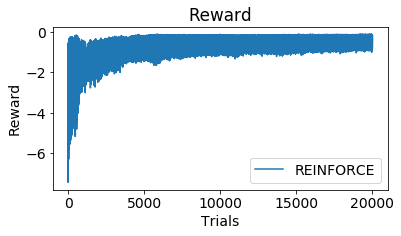

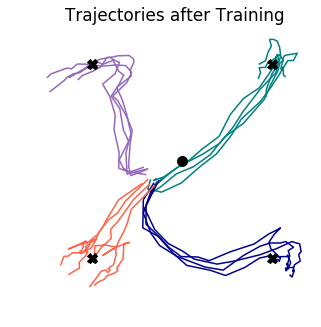

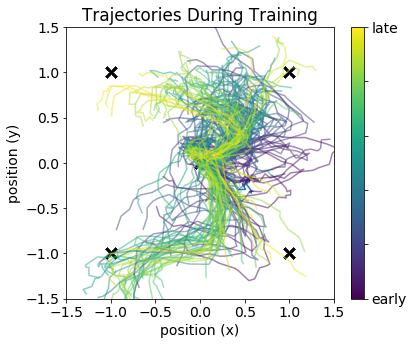

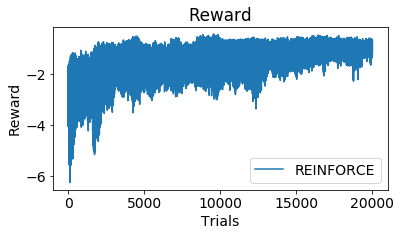

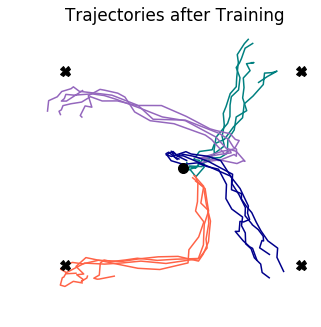

In [13]:


for sl in [slice(0,2),slice(2,4),slice(4,6)]:
    
    """ Test new decoder """

    net1 = RNN(params)

    net1.set_weights(w_in=np.copy(net0.w_in),w_rec=np.copy(net0.w_rec))

    #net1.set_weights(w_out=D@C, w_m=(D@C).T) # set w_out and w_m
    """ set weights to just C"""
    net1.set_weights(w_out=C[sl,:], w_m=(C[0:2,:]).T) # set w_out and w_m << internal matrix is only first two PCs

    # initialize simulation, no learning here
    sim1 = Simulation(net1)
    reinforce = REINFORCE(net1,apply_to=['w_rec'],tau_reward=5) 
    sim1.run_session(n_trials=20000, tasks=[task1,task2,task3,task4], learn_alg=[reinforce], probe_types=['h','y_out','pos'], plot=True, plot_freq=100,train=True)
    #sim1.run_session(n_trials=100, tasks=[task1,task2,task3,task4], learn_alg=[], probe_types=['h','y_out','pos'], plot=True, plot_freq=1,train=False)


    fig = plot_trained_trajectories(sim=sim1, tasks=[task1,task2,task3,task4])


### This is great! REINFORCE learns where RFLO does not!

## Experiment 3 - RFLO with Remapping onto Orthogonal PCs, _with_ Driving Feedback

* Credit Assignment Matrix M is based on top 10 PCs, but decoder is switched to consecutively lower PCs. Since they are orthogonal, will SL _not_ be able to learn the task?

In [14]:
params1 = RNNparams(n_in=4,n_rec=50,n_out=2,tau_rec=8,
               eta_in=0.1,eta_rec=0.25,eta_out=0.1,eta_fb=0.5,
               sig_in=0.01,sig_rec=0.25,sig_out=0.01, sig_fb=0.01,
               velocity_transform=False, tau_vel = 2, dt_vel = 0.1,
               driving_feedback=True,
               rng=np.random.RandomState(2))

20000it [00:45, 437.51it/s]
20000it [00:52, 377.87it/s]
20000it [00:44, 446.95it/s]


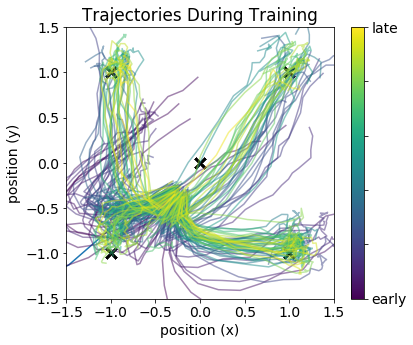

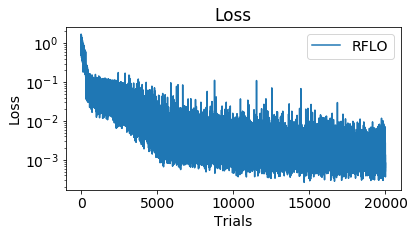

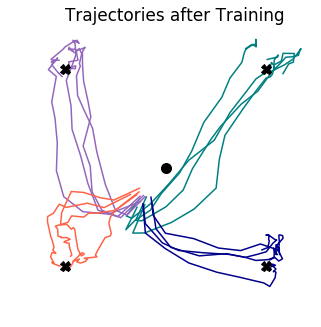

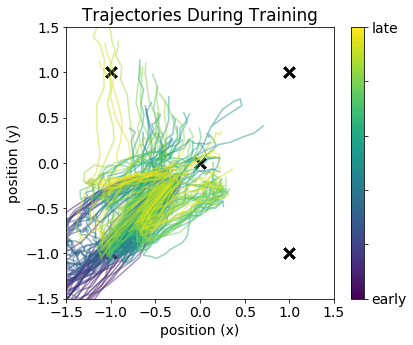

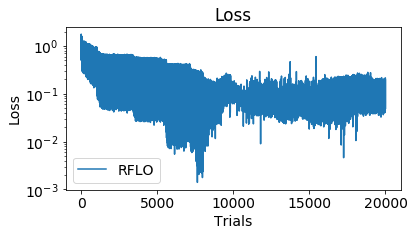

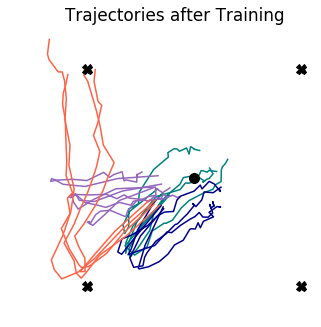

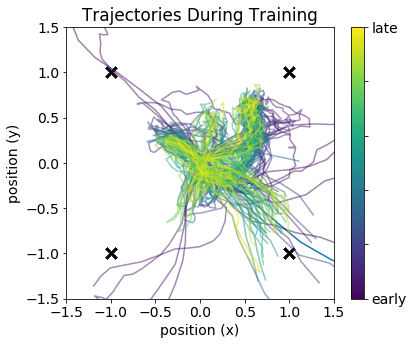

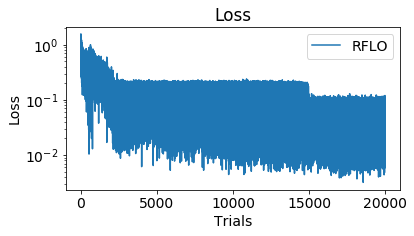

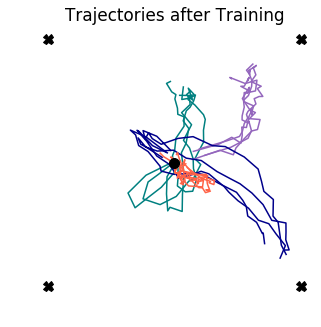

In [19]:
for sl in [slice(0,2),slice(2,4),slice(4,6)]:
    
    """ Test new decoder """

    net1 = RNN(params1)

    net1.set_weights(w_in=np.copy(net0.w_in),w_rec=np.copy(net0.w_rec))
    
                     
    #net1.set_weights(w_out=D@C, w_m=(D@C).T) # set w_out and w_m
    """ set weights to just C"""
    net1.set_weights(w_out=C[sl,:], w_m=(C[0:2,:]).T) # set w_out and w_m << internal matrix is only first two PCs
    net1.set_weights(w_fb=10*(C[sl,:]).T)
                     
    # initialize simulation, no learning here
    sim1 = Simulation(net1)
    rflo1 = RFLO(net1,apply_to=['w_rec']) 
    sim1.run_session(n_trials=20000, tasks=[task1,task2,task3,task4], learn_alg=[rflo1], probe_types=['h','y_out','pos'], plot=True, plot_freq=100,train=True)
    #sim1.run_session(n_trials=100, tasks=[task1,task2,task3,task4], learn_alg=[], probe_types=['h','y_out','pos'], plot=True, plot_freq=1,train=False)


    fig = plot_trained_trajectories(sim=sim1, tasks=[task1,task2,task3,task4])


In [21]:
FactorAnalysis?

Init signature:
FactorAnalysis(
    ['n_components=None', 'tol=0.01', 'copy=True', 'max_iter=1000', 'noise_variance_init=None', "svd_method='randomized'", 'iterated_power=3', 'random_state=0'],
)
Docstring:     
Factor Analysis (FA)

A simple linear generative model with Gaussian latent variables.

The observations are assumed to be caused by a linear transformation of
lower dimensional latent factors and added Gaussian noise.
Without loss of generality the factors are distributed according to a
Gaussian with zero mean and unit covariance. The noise is also zero mean
and has an arbitrary diagonal covariance matrix.

If we would restrict the model further, by assuming that the Gaussian
noise is even isotropic (all diagonal entries are the same) we would obtain
:class:`PPCA`.

FactorAnalysis performs a maximum likelihood estimate of the so-called
`loading` matrix, the transformation of the latent variables to the
observed ones, using expectation-maximization (EM).

Read more in the :ref: